In [3]:
! pip install tflite-model-maker tensorflow==2.9

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 642 kB 5.1 MB/s 
     |████████████████████████████████| 511.7 MB 4.0 kB/s 
     |████████████████████████████████| 1.6 MB 43.4 MB/s 
     |████████████████████████████████| 5.8 MB 41.6 MB/s 
     |████████████████████████████████| 438 kB 54.0 MB/s 
     |████████████████████████████████| 840 kB 26.3 MB/s 
     |████████████████████████████████| 596 kB 21.2 MB/s 
     |████████████████████████████████| 6.4 MB 15.2 MB/s 
     |████████████████████████████████| 1.1 MB 15.8 MB/s 
     |████████████████████████████████| 3.4 MB 59.5 MB/s 
     |████████████████████████████████| 42.6 MB 1.2 MB/s 
     |████████████████████████████████| 1.2 MB 15.6 MB/s 
     |████████████████████████████████| 120 kB 16.6 MB/s 
     |████████████████████████████████| 10.9 MB 30.4 MB/s 
     |████████████████████████████████| 237 kB 49.5 MB/s 
     |████████████████████████

***The TensorFlow Lite Model Maker library simplifies the process of training a TensorFlow Lite model using custom dataset. It uses transfer learning to reduce the amount of training data required and shorten the training time.***

In [1]:
!pip install tensorflow_io

import tensorflow_io as tfio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 25.9 MB 4.0 MB/s 


In [2]:
import tensorflow as tf
import tflite_model_maker as mm
from tflite_model_maker import audio_classifier
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import glob
import random

from IPython.display import Audio, Image
from scipy.io import wavfile


**Here the data is stored in the drive and is mounted to colab, the following is the path provided.**

**We have tried to plot a graph of any random .wav file on amplitude and time**

https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.wavfile.read.html

In [20]:
dir = '/content/drive/MyDrive/AS/audiosets/sounds'

test_data = os.path.join('/content','/content/drive/MyDrive/AS/audiosets/sounds', 'train/*/*.wav')

test_list = glob.glob(test_data)

random_file = random.choice(test_list)

samplerate, data = wavfile.read(random_file, 'rb')
print(f"number of channels = {data.shape[1]}")

length = data.shape[0] / samplerate
print(f"length = {length}s")



number of channels = 2
length = 3.0s


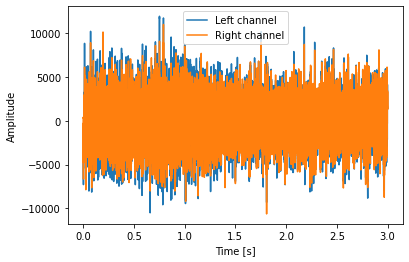

In [21]:
import matplotlib.pyplot as plt
import numpy as np
time = np.linspace(0., length, data.shape[0])
plt.plot(time, data[:, 0], label="Left channel")
plt.plot(time, data[:, 1], label="Right channel")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

# **YAMNet**

is a pre-trained neural network that employs the MobileNetV1 depthwise-separable convolution architecture. It can use an audio waveform as input and make independent predictions for each of the 521 audio events from the AudioSet corpus.

Internally, the model extracts "frames" from the audio signal and processes batches of these frames. This version of the model uses frames that are 0.96 second long and extracts one frame every 0.48 seconds .

The model accepts a 1-D float32 Tensor or NumPy array containing a waveform of arbitrary length, represented as single-channel (mono) 16 kHz samples in the range [-1.0, +1.0]. This tutorial contains code to help you convert WAV files into the supported format.

In [4]:
import tensorflow_hub as hub
import pandas as pd

yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

https://www.tensorflow.org/tutorials/audio/transfer_learning_audio

***Example classes***

In [5]:
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])

for name in class_names[:20]:
  print(name)
print('...')

Speech
Child speech, kid speaking
Conversation
Narration, monologue
Babbling
Speech synthesizer
Shout
Bellow
Whoop
Yell
Children shouting
Screaming
Whispering
Laughter
Baby laughter
Giggle
Snicker
Belly laugh
Chuckle, chortle
Crying, sobbing
...


***Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio.***

In [8]:
# Utility functions for loading audio files and making sure the sample rate is correct.

@tf.function
def load_wav_16k_mono(filename):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

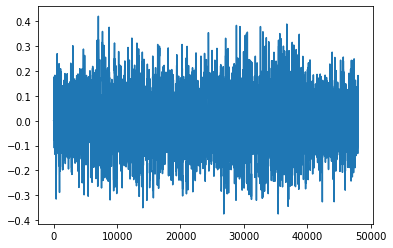

In [9]:
test_sample = load_wav_16k_mono(random_file)

_ = plt.plot(test_sample)


***The model returns 3 outputs, including the class scores, embeddings (which you will use for transfer learning), and the log mel spectrogram.***

In [10]:
scores, embeddings, spectrogram = yamnet_model(test_sample)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.argmax(class_scores)
inferred_class = class_names[top_class]

print(f'The main sound is: {inferred_class}')
print(f'The embeddings shape: {embeddings.shape}')

The main sound is: Vehicle
The embeddings shape: (6, 1024)


Fetching train and test data

In [26]:
train_data = audio_classifier.DataLoader.from_folder(
    spec, os.path.join(dir, 'train'), cache=True)
train_data, validation_data = train_data.split(0.8)
test_data = audio_classifier.DataLoader.from_folder(
    spec, os.path.join(dir, 'test'), cache=True)

***Creating an YamNetspec base model that can be used in our architecture***

In [6]:
spec = audio_classifier.YamNetSpec(
    keep_yamnet_and_custom_heads=True)

INFO:tensorflow:Checkpoints are stored in /tmp/tmpubfuzqjz


INFO:tensorflow:Checkpoints are stored in /tmp/tmpubfuzqjz


In [22]:

print('Training the model')
model = audio_classifier.create(
    train_data,
    spec,
    validation_data,
    epochs=10)

Training the model
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 classification_head (Dense)  (None, 3)                3075      
                                                                 
Total params: 3,075
Trainable params: 3,075
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
60/60 [==============================] - 88s 1s/step - loss: 0.5983 - acc: 0.7864 - val_loss: 0.3008 - val_acc: 0.9458
Epoch 2/10
60/60 [==============================] - 0s 7ms/step - loss: 0.2800 - acc: 0.9262 - val_loss: 0.2021 - val_acc: 0.9521
Epoch 3/10
60/60 [==============================] - 1s 10ms/step - loss: 0.2168 - acc: 0.9351 - val_loss: 0.1702 - val_acc: 0.9583
Epoch 4/10
60/60 [==============================] - 1s 8ms/step - loss: 0.1869 - acc: 0.9403 - val_loss: 0.1567 - val_acc: 0.9563
Epoch 5/10
60/60 [======================

In [27]:
print('Evaluating the model')
model.evaluate(test_data)

Evaluating the model
20/20 [==============================] - 21s 969ms/step - loss: 0.2250 - acc: 0.9115


[0.22498208284378052, 0.911475419998169]

1/1 [==============================] - 0s 50ms/step


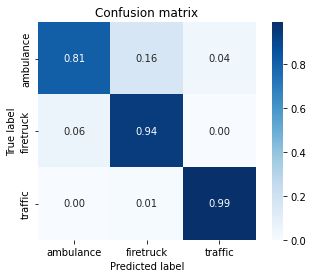

In [14]:
def show_confusion_matrix(confusion, test_labels):
  """Compute confusion matrix and normalize."""
  confusion_normalized = confusion.astype("float") / confusion.sum(axis=1)
  axis_labels = test_labels
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.2f', square=True)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

confusion_matrix = model.confusion_matrix(test_data)
show_confusion_matrix(confusion_matrix.numpy(), test_data.index_to_label)

#### REFERENCES:

1. https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/audio_classifier/YamNetSpec


2. https://www.tensorflow.org/lite/api_docs/java/org/tensorflow/lite/task/audio/classifier/AudioClassifier. 